In [5]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

## Scence, Collections

In [6]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()    

## RBTree

In [7]:
from operator import attrgetter
_sentinel = object()

class _ABCTree(object):
    def __init__(self, cmp=None, cmp_data=None):
        """T.__init__(...) initializes T; see T.__class__.__doc__ for signature"""
        self._root = None
        self._count = 0
        if cmp is None:
            def cmp(cmp_data, a, b):
                if a < b:
                    return -1
                elif a > b:
                    return 1
                else:
                    return 0
        self._cmp = cmp
        self._cmp_data = cmp_data

    def clear(self):
        """T.clear() -> None.  Remove all items from T."""
        def _clear(node):
            if node is not None:
                _clear(node.left)
                _clear(node.right)
                node.free()
        _clear(self._root)
        self._count = 0
        self._root = None

    @property
    def count(self):
        """Get items count."""
        return self._count

    def get_value(self, key):
        node = self._root
        while node is not None:
            cmp = self._cmp(self._cmp_data, key, node.key)
            if cmp == 0:
                return node.value
            elif cmp < 0:
                node = node.left
            else:
                node = node.right
        raise KeyError(str(key))

    def pop_item(self):
        """T.pop_item() -> (k, v), remove and return some (key, value) pair as a
        2-tuple; but raise KeyError if T is empty.
        """
        if self.is_empty():
            raise KeyError("pop_item(): tree is empty")
        node = self._root
        while True:
            if node.left is not None:
                node = node.left
            elif node.right is not None:
                node = node.right
            else:
                break
        key = node.key
        value = node.value
        self.remove(key)
        return key, value
    popitem = pop_item  # for compatibility  to dict()

    def min_item(self):
        """Get item with min key of tree, raises ValueError if tree is empty."""
        if self.is_empty():
            raise ValueError("Tree is empty")
        node = self._root
        while node.left is not None:
            node = node.left
        return node.key, node.value

    def max_item(self):
        """Get item with max key of tree, raises ValueError if tree is empty."""
        if self.is_empty():
            raise ValueError("Tree is empty")
        node = self._root
        while node.right is not None:
            node = node.right
        return node.key, node.value

    def succ_item(self, key, default=_sentinel):
        """Get successor (k,v) pair of key, raises KeyError if key is max key
        or key does not exist. optimized for pypy.
        """
        # removed graingets version, because it was little slower on CPython and much slower on pypy
        # this version runs about 4x faster with pypy than the Cython version
        # Note: Code sharing of succ_item() and ceiling_item() is possible, but has always a speed penalty.
        node = self._root
        succ_node = None
        while node is not None:
            cmp = self._cmp(self._cmp_data, key, node.key)
            if cmp == 0:
                break
            elif cmp < 0:
                if (succ_node is None) or self._cmp(self._cmp_data, node.key, succ_node.key) < 0:
                    succ_node = node
                node = node.left
            else:
                node = node.right

        if node is None:  # stay at dead end
            if default is _sentinel:
                raise KeyError(str(key))
            return default
        # found node of key
        if node.right is not None:
            # find smallest node of right subtree
            node = node.right
            while node.left is not None:
                node = node.left
            if succ_node is None:
                succ_node = node
            elif self._cmp(self._cmp_data, node.key, succ_node.key) < 0:
                succ_node = node
        elif succ_node is None:  # given key is biggest in tree
            if default is _sentinel:
                raise KeyError(str(key))
            return default
        return succ_node.key, succ_node.value

    def prev_item(self, key, default=_sentinel):
        """Get predecessor (k,v) pair of key, raises KeyError if key is min key
        or key does not exist. optimized for pypy.
        """
        # removed graingets version, because it was little slower on CPython and much slower on pypy
        # this version runs about 4x faster with pypy than the Cython version
        # Note: Code sharing of prev_item() and floor_item() is possible, but has always a speed penalty.
        node = self._root
        prev_node = None

        while node is not None:
            cmp = self._cmp(self._cmp_data, key, node.key)
            if cmp == 0:
                break
            elif cmp < 0:
                node = node.left
            else:
                if (prev_node is None) or self._cmp(self._cmp_data, prev_node.key, node.key) < 0:
                    prev_node = node
                node = node.right

        if node is None:  # stay at dead end (None)
            if default is _sentinel:
                raise KeyError(str(key))
            return default
        # found node of key
        if node.left is not None:
            # find biggest node of left subtree
            node = node.left
            while node.right is not None:
                node = node.right
            if prev_node is None:
                prev_node = node
            elif self._cmp(self._cmp_data, prev_node.key, node.key) < 0:
                prev_node = node
        elif prev_node is None:  # given key is smallest in tree
            if default is _sentinel:
                raise KeyError(str(key))
            return default
        return prev_node.key, prev_node.value

    def __repr__(self):
        """T.__repr__(...) <==> repr(x)"""
        tpl = "%s({%s})" % (self.__class__.__name__, '%s')
        return tpl % ", ".join(("%r: %r" % item for item in self.items()))

    def __contains__(self, key):
        """k in T -> True if T has a key k, else False"""
        try:
            self.get_value(key)
            return True
        except KeyError:
            return False

    def __len__(self):
        """T.__len__() <==> len(x)"""
        return self.count

    def is_empty(self):
        """T.is_empty() -> False if T contains any items else True"""
        return self.count == 0

    def set_default(self, key, default=None):
        """T.set_default(k[,d]) -> T.get(k,d), also set T[k]=d if k not in T"""
        try:
            return self.get_value(key)
        except KeyError:
            self.insert(key, default)
            return default
    setdefault = set_default  # for compatibility to dict()

    def get(self, key, default=None):
        """T.get(k[,d]) -> T[k] if k in T, else d.  d defaults to None."""
        try:
            return self.get_value(key)
        except KeyError:
            return default

    def pop(self, key, *args):
        """T.pop(k[,d]) -> v, remove specified key and return the corresponding value.
        If key is not found, d is returned if given, otherwise KeyError is raised
        """
        if len(args) > 1:
            raise TypeError("pop expected at most 2 arguments, got %d" % (1 + len(args)))
        try:
            value = self.get_value(key)
            self.remove(key)
            return value
        except KeyError:
            if len(args) == 0:
                raise
            else:
                return args[0]

    def prev_key(self, key, default=_sentinel):
        """Get predecessor to key, raises KeyError if key is min key
        or key does not exist.
        """
        item = self.prev_item(key, default)
        return default if item is default else item[0]

    def succ_key(self, key, default=_sentinel):
        """Get successor to key, raises KeyError if key is max key
        or key does not exist.
        """
        item = self.succ_item(key, default)
        return default if item is default else item[0]

    def pop_min(self):
        """T.pop_min() -> (k, v), remove item with minimum key, raise ValueError
        if T is empty.
        """
        item = self.min_item()
        self.remove(item[0])
        return item

    def pop_max(self):
        """T.pop_max() -> (k, v), remove item with maximum key, raise ValueError
        if T is empty.
        """
        item = self.max_item()
        self.remove(item[0])
        return item

    def min_key(self):
        """Get min key of tree, raises ValueError if tree is empty. """
        return self.min_item()[0]

    def max_key(self):
        """Get max key of tree, raises ValueError if tree is empty. """
        return self.max_item()[0]

    def key_slice(self, start_key, end_key, reverse=False):
        """T.key_slice(start_key, end_key) -> key iterator:
        start_key <= key < end_key.
        Yields keys in ascending order if reverse is False else in descending order.
        """
        return (k for k, v in self.iter_items(start_key, end_key, reverse=reverse))

    def iter_items(self,  start_key=None, end_key=None, reverse=False):
        """Iterates over the (key, value) items of the associated tree,
        in ascending order if reverse is True, iterate in descending order,
        reverse defaults to False"""
        # optimized iterator (reduced method calls) - faster on CPython but slower on pypy

        if self.is_empty():
            return []
        if reverse:
            return self._iter_items_backward(start_key, end_key)
        else:
            return self._iter_items_forward(start_key, end_key)

    def _iter_items_forward(self, start_key=None, end_key=None):
        for item in self._iter_items(left=attrgetter("left"), right=attrgetter("right"),
                                     start_key=start_key, end_key=end_key):
            yield item

    def _iter_items_backward(self, start_key=None, end_key=None):
        for item in self._iter_items(left=attrgetter("right"), right=attrgetter("left"),
                                     start_key=start_key, end_key=end_key):
            yield item

    def _iter_items(self, left=attrgetter("left"), right=attrgetter("right"), start_key=None, end_key=None):
        node = self._root
        stack = []
        go_left = True
        in_range = self._get_in_range_func(start_key, end_key)

        while True:
            if left(node) is not None and go_left:
                stack.append(node)
                node = left(node)
            else:
                if in_range(node.key):
                    yield node.key, node.value
                if right(node) is not None:
                    node = right(node)
                    go_left = True
                else:
                    if not len(stack):
                        return  # all done
                    node = stack.pop()
                    go_left = False

    def _get_in_range_func(self, start_key, end_key):
        if start_key is None and end_key is None:
            return lambda x: True
        else:
            if start_key is None:
                start_key = self.min_key()
            if end_key is None:
                return (lambda x: self._cmp(self._cmp_data, start_key, x) <= 0)
            else:
                return (lambda x: self._cmp(self._cmp_data, start_key, x) <= 0 and
                        self._cmp(self._cmp_data, x, end_key) < 0)


# ------
# RBTree

class Node(object):
    """Internal object, represents a tree node."""
    __slots__ = ['key', 'value', 'red', 'left', 'right']

    def __init__(self, key=None, value=None):
        self.key = key
        self.value = value
        self.red = True
        self.left = None
        self.right = None

    def free(self):
        self.left = None
        self.right = None
        self.key = None
        self.value = None

    def __getitem__(self, key):
        """N.__getitem__(key) <==> x[key], where key is 0 (left) or 1 (right)."""
        return self.left if key == 0 else self.right

    def __setitem__(self, key, value):
        """N.__setitem__(key, value) <==> x[key]=value, where key is 0 (left) or 1 (right)."""
        if key == 0:
            self.left = value
        else:
            self.right = value


class RBTree(_ABCTree):
    """
    RBTree implements a balanced binary tree with a dict-like interface.
    see: http://en.wikipedia.org/wiki/Red_black_tree
    """
    @staticmethod
    def is_red(node):
        if (node is not None) and node.red:
            return True
        else:
            return False

    @staticmethod
    def jsw_single(root, direction):
        other_side = 1 - direction
        save = root[other_side]
        root[other_side] = save[direction]
        save[direction] = root
        root.red = True
        save.red = False
        return save

    @staticmethod
    def jsw_double(root, direction):
        other_side = 1 - direction
        root[other_side] = RBTree.jsw_single(root[other_side], other_side)
        return RBTree.jsw_single(root, direction)

    def _new_node(self, key, value):
        """Create a new tree node."""
        self._count += 1
        return Node(key, value)

    def insert(self, key, value):
        """T.insert(key, value) <==> T[key] = value, insert key, value into tree."""
        if self._root is None:  # Empty tree case
            self._root = self._new_node(key, value)
            self._root.red = False  # make root black
            return

        head = Node()  # False tree root
        grand_parent = None
        grand_grand_parent = head
        parent = None  # parent
        direction = 0
        last = 0

        # Set up helpers
        grand_grand_parent.right = self._root
        node = grand_grand_parent.right
        # Search down the tree
        while True:
            if node is None:  # Insert new node at the bottom
                node = self._new_node(key, value)
                parent[direction] = node
            elif RBTree.is_red(node.left) and RBTree.is_red(node.right):  # Color flip
                node.red = True
                node.left.red = False
                node.right.red = False

            # Fix red violation
            if RBTree.is_red(node) and RBTree.is_red(parent):
                direction2 = 1 if grand_grand_parent.right is grand_parent else 0
                if node is parent[last]:
                    grand_grand_parent[direction2] = RBTree.jsw_single(grand_parent, 1 - last)
                else:
                    grand_grand_parent[direction2] = RBTree.jsw_double(grand_parent, 1 - last)

            # Stop if found
            if self._cmp(self._cmp_data, key, node.key) == 0:
                node.value = value  # set new value for key
                break

            last = direction
            direction = 0 if (self._cmp(self._cmp_data, key, node.key) < 0) else 1
            # Update helpers
            if grand_parent is not None:
                grand_grand_parent = grand_parent
            grand_parent = parent
            parent = node
            node = node[direction]

        self._root = head.right  # Update root
        self._root.red = False  # make root black

    def remove(self, key):
        """T.remove(key) <==> del T[key], remove item <key> from tree."""
        if self._root is None:
            raise KeyError(str(key))
        head = Node()  # False tree root
        node = head
        node.right = self._root
        parent = None
        grand_parent = None
        found = None  # Found item
        direction = 1

        # Search and push a red down
        while node[direction] is not None:
            last = direction

            # Update helpers
            grand_parent = parent
            parent = node
            node = node[direction]

            direction = 1 if (self._cmp(self._cmp_data, node.key, key) < 0) else 0

            # Save found node
            if self._cmp(self._cmp_data, key, node.key) == 0:
                found = node

            # Push the red node down
            if not RBTree.is_red(node) and not RBTree.is_red(node[direction]):
                if RBTree.is_red(node[1 - direction]):
                    parent[last] = RBTree.jsw_single(node, direction)
                    parent = parent[last]
                elif not RBTree.is_red(node[1 - direction]):
                    sibling = parent[1 - last]
                    if sibling is not None:
                        if (not RBTree.is_red(sibling[1 - last])) and (not RBTree.is_red(sibling[last])):
                            # Color flip
                            parent.red = False
                            sibling.red = True
                            node.red = True
                        else:
                            direction2 = 1 if grand_parent.right is parent else 0
                            if RBTree.is_red(sibling[last]):
                                grand_parent[direction2] = RBTree.jsw_double(parent, last)
                            elif RBTree.is_red(sibling[1-last]):
                                grand_parent[direction2] = RBTree.jsw_single(parent, last)
                            # Ensure correct coloring
                            grand_parent[direction2].red = True
                            node.red = True
                            grand_parent[direction2].left.red = False
                            grand_parent[direction2].right.red = False

        if found is not None:
            found.key = node.key
            found.value = node.value
            parent[int(parent.right is node)] = node[int(node.left is None)]
            node.free()
            self._count -= 1

        # Update root and make it black
        self._root = head.right
        if self._root is not None:
            self._root.red = False
        if not found:
            raise KeyError(str(key))

## Funkcje pomocnicze

In [8]:
eps = 1e-10

def slope_f(p1, p2):
    if p1[0] == p2[0]:
        if p1[1] < p2[1]:
            return float("inf")
        else:
            return -float("inf")
    else:
        return (p2[1] - p1[1]) / (p2[0] - p1[0])

def sub(a, b):
    return (
        a[0] - b[0],
        a[1] - b[1])

def dot_f(a, b):
    return (
        (a[0] * b[0]) +
        (a[1] * b[1]))

def line_point_factor(p, l1, l2, default=0.0):
    u = sub(l2, l1)
    h = sub(p, l1)
    dot = dot_f(u, u)
    return (dot_f(u, h) / dot) if dot != 0.0 else default


def intersection(v1, v2, v3, v4, bias=0.0):
    if v1 > v2:
        v1, v2 = v2, v1
    if v3 > v4:
        v3, v4 = v4, v3
    if (v1, v2) > (v3, v4):
        v1, v2, v3, v4 = v3, v4, v1, v2

    div = (v2[0] - v1[0]) * (v4[1] - v3[1]) - (v2[1] - v1[1]) * (v4[0] - v3[0])
    if div == 0.0:
        return None

    vi = (((v3[0] - v4[0]) *
           (v1[0] * v2[1] - v1[1] * v2[0]) - (v1[0] - v2[0]) *
           (v3[0] * v4[1] - v3[1] * v4[0])) / div,
          ((v3[1] - v4[1]) *
           (v1[0] * v2[1] - v1[1] * v2[0]) - (v1[1] - v2[1]) *
           (v3[0] * v4[1] - v3[1] * v4[0])) / div,
          )

    fac = line_point_factor(vi, v1, v2, default=-1.0)
    if fac < 0.0 - bias or fac > 1.0 + bias:
        return None

    fac = line_point_factor(vi, v3, v4, default=-1.0)
    if fac < 0.0 - bias or fac > 1.0 + bias:
        return None

    return vi

## Struktury

In [51]:
class Event:

    class Type:
        END = 0
        INTERSECTION = 1
        START = 2

    def __init__(self, type, point, segment, slope):
        assert(isinstance(point, tuple))
        self.type = type
        self.point = point
        self.segment = segment

        self.slope = slope
        if segment is not None:
            self.span = segment[1][0] - segment[0][0]

    def __hash__(self):
        return hash(self.point)

    def y_intercept_x(self, x):

        if x <= self.segment[0][0]:
            return self.segment[0][1]
        elif x >= self.segment[1][0]:
            return self.segment[1][1]

        delta_x0 = x - self.segment[0][0]
        delta_x1 = self.segment[1][0] - x
        if delta_x0 > delta_x1:
            ifac = delta_x0 / self.span
            fac = 1.0 - ifac
        else:
            fac = delta_x1 / self.span
            ifac = 1.0 - fac
        assert(fac <= 1.0)
        return (self.segment[0][1] * fac) + (self.segment[1][1] * ifac)

    @staticmethod
    def Compare(sweep_line, this, that):
        if this is that:
            return 0
        current_point_x = sweep_line._current_event_point_x
        this_y = this.y_intercept_x(current_point_x)
        that_y = that.y_intercept_x(current_point_x)

        delta_y = this_y - that_y

        assert((delta_y < 0.0) == (this_y < that_y))
        if abs(delta_y) > eps:
            return -1 if (delta_y < 0.0) else 1
        else:
            this_slope = this.slope
            that_slope = that.slope
            if this_slope != that_slope:
                if sweep_line._before:
                    return -1 if (this_slope > that_slope) else 1
                else:
                    return 1 if (this_slope > that_slope) else -1

        delta_x_p1 = this.segment[0][0] - that.segment[0][0]
        if delta_x_p1 != 0.0:
            return -1 if (delta_x_p1 < 0.0) else 1

        delta_x_p2 = this.segment[1][0] - that.segment[1][0]
        if delta_x_p2 != 0.0:
            return -1 if (delta_x_p2 < 0.0) else 1

        return 0


class SweepLine:

    def __init__(self, segments):
        self.intersections = {}

        self._current_event_point_x = None
        self._events_current_sweep = RBTree(cmp=Event.Compare, cmp_data=self)
        self._before = True
        self.segments = segments
        
        self.scences = []

    def get_intersections(self):
        return list(self.intersections.keys())

    def _check_intersection(self, a: Event, b: Event):
        if ((a is None or b is None) or
            (a.type == Event.Type.INTERSECTION) or
            (b.type == Event.Type.INTERSECTION)):
            return

        if a is b:
            return

        p = intersection(
            a.segment[0], a.segment[1],
            b.segment[0], b.segment[1],
        )

        if p is None:
            return


        events_for_point = self.intersections.pop(p, set())
        is_new = len(events_for_point) == 0
        events_for_point.add(a)
        events_for_point.add(b)
        self.intersections[p] = events_for_point

        if is_new and p[0] >= self._current_event_point_x:
            event_isect = Event(Event.Type.INTERSECTION, p, None, None)
            self.queue.offer(p, event_isect)

    def _sweep_to(self, p):
        if p[0] == self._current_event_point_x:
            return

        self._current_event_point_x = p[0]

    def insert(self, event):
        assert(event not in self._events_current_sweep)


        self._events_current_sweep.insert(event, None)

    def remove(self, event):
        try:
            self._events_current_sweep.remove(event)
            return True
        except KeyError:
            return False

    def above(self, event):
        return self._events_current_sweep.succ_key(event, None)

    def below(self, event):
        return self._events_current_sweep.prev_key(event, None)

    def above_all(self, event):
        return self._events_current_sweep.key_slice(event, None, reverse=False)

    def handle(self, p, events_current):
        if len(events_current) == 0:
            return
        assert(p[0] == self._current_event_point_x)

        if len(events_current) > 1:
            for i in range(0, len(events_current) - 1):
                for j in range(i + 1, len(events_current)):
                    self._check_intersection(
                        events_current[i], events_current[j])

        for e in events_current:
            self.handle_event(e)

    def handle_event(self, event):
        color = None
        t = event.type
        if t == Event.Type.START:
            color = "green"
            self._before = False
            self.insert(event)

            e_above = self.above(event)
            e_below = self.below(event)

            self._check_intersection(event, e_above)
            self._check_intersection(event, e_below)

        elif t == Event.Type.END:
            color = "m"
            self._before = True

            e_above = self.above(event)
            e_below = self.below(event)

            self.remove(event)

            self._check_intersection(e_above, e_below)

        elif t == Event.Type.INTERSECTION:
            color = "black"
            self._before = True
            event_set = self.intersections[event.point]
            reinsert_stack = []
            for e in event_set:
                if self.remove(e):
                    reinsert_stack.append(e)
            self._before = False

            while reinsert_stack:
                e = reinsert_stack.pop()

                self.insert(e)

                e_above = self.above(e)
                e_below = self.below(e)

                self._check_intersection(e, e_above)
                self._check_intersection(e, e_below)
                    
        points = [
            PointsCollection([isec for isec in self.intersections], color="red"),
            PointsCollection([event.point], color=color)
        ]
        
        lines = [LinesCollection(self.segments), 
                 LinesCollection([event.segment], color="orange")] if event.segment else [LinesCollection(self.segments)]
           
        scene = Scene(points, lines)
        self.scences.append(scene)
        
class EventQueue:

    def __init__(self, segments, line: SweepLine):
        self.events_scan = RBTree()

        for s in segments:
            assert(s[0][0] <= s[1][0])

            slope = slope_f(*s)

            if s[0] == s[1]:
                pass
            else:
                e_start = Event(Event.Type.START, s[0], s, slope)
                e_end   = Event(Event.Type.END,   s[1], s, slope)

                self.offer(s[0], e_start)
                self.offer(s[1], e_end)

        line.queue = self

    def offer(self, p, e: Event):
        existing = self.events_scan.setdefault(
            p, ([], [], []),
        )
        existing[e.type].append(e)

    def poll(self):
        assert(len(self.events_scan) != 0)
        p, events_current = self.events_scan.pop_min()
        return p, events_current

## Algorytm zamiatania

In [52]:
def sweep(segments):
    segments = [(s[0], s[1]) if (s[0] <= s[1]) else (s[1], s[0]) for s in segments]

    sweep_line = SweepLine(segments)
    queue = EventQueue(segments, sweep_line)
    scences = []

    while len(queue.events_scan) > 0:
        p, e_ls = queue.poll()
        for events_current in e_ls:
            if events_current:
                sweep_line._sweep_to(p)
                sweep_line.handle(p, events_current)

    return sweep_line.get_intersections(), sweep_line.scences

## Algorytm naiwny

In [53]:
def naive(segments):
    isect = []

    segments = [(s[0], s[1]) if (s[0] <= s[1]) else (s[1], s[0]) for s in segments]

    n = len(segments)

    for i in range(n):
        a0, a1 = segments[i]
        for j in range(i + 1, n):
            b0, b1 = segments[j]
            if a0 not in (b0, b1) and a1 not in (b0, b1):
                ix = intersection(a0, a1, b0, b1)
                if ix is not None:
                    isect.append(ix)

    return isect

## Generowanie linii

In [54]:
def generate_point(min, max):
    a = np.random.uniform(min, max)
    b = np.random.uniform(min, max)
    while a == b:
        b = np.random.uniform(min, max)
    return (a, b)

def generate_line(min, max, quantity):
    i = 0
    xs = set()
    lines = []
    while i != quantity:
        point_a = generate_point(min, max)
        point_b = generate_point(min, max)
        if point_a[0] not in xs and point_b[0] not in xs:
            lines.append((point_a, point_b))
            xs.add(point_a[0])
            xs.add(point_b[0])
            i += 1
    return lines

## Własne punkty

<IPython.core.display.Javascript object>


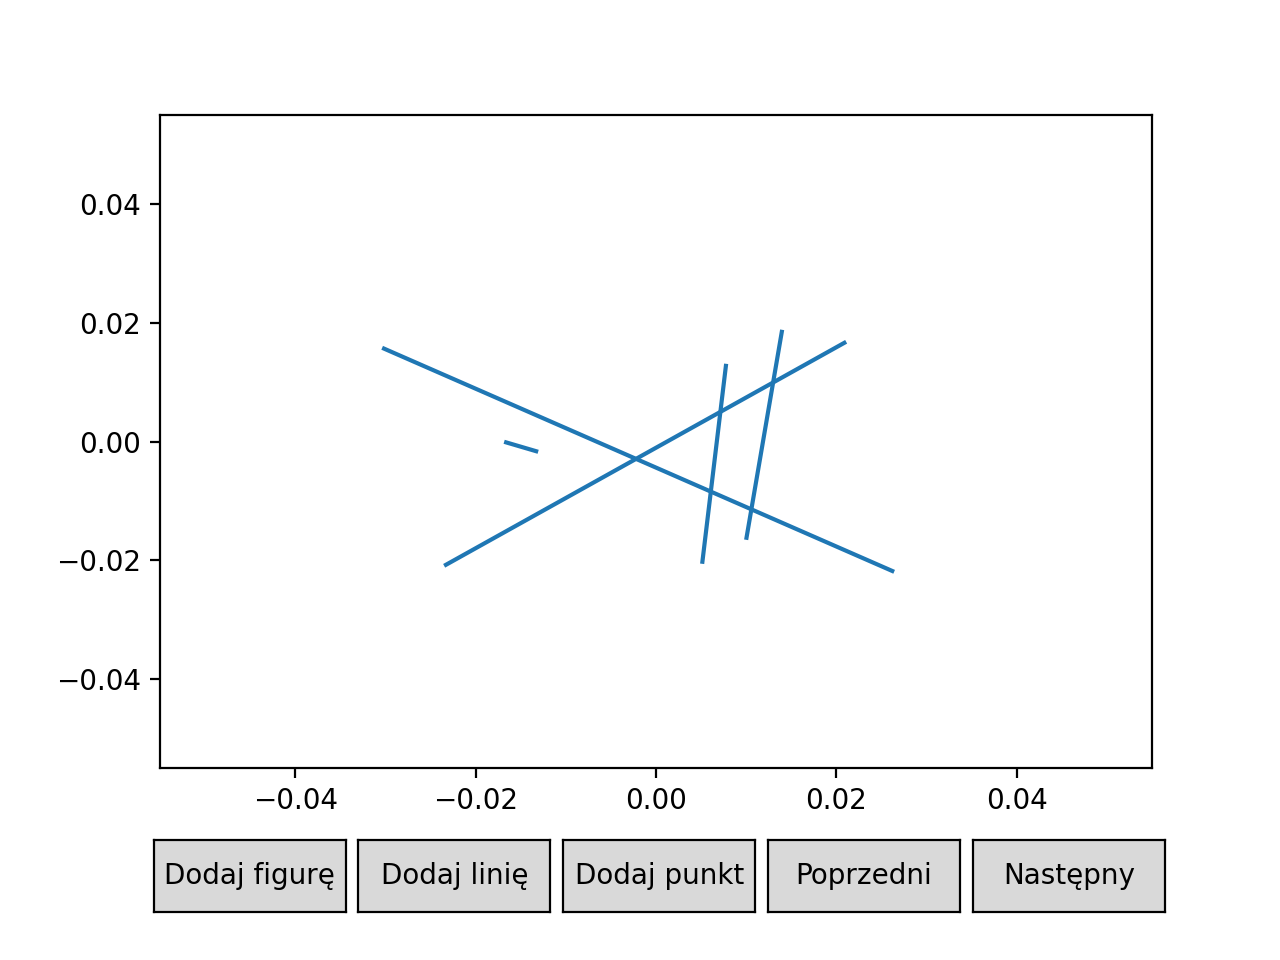

In [62]:
%matplotlib notebook
plot=Plot()
plot.draw()

2
2
2
2
2
5


<IPython.core.display.Javascript object>


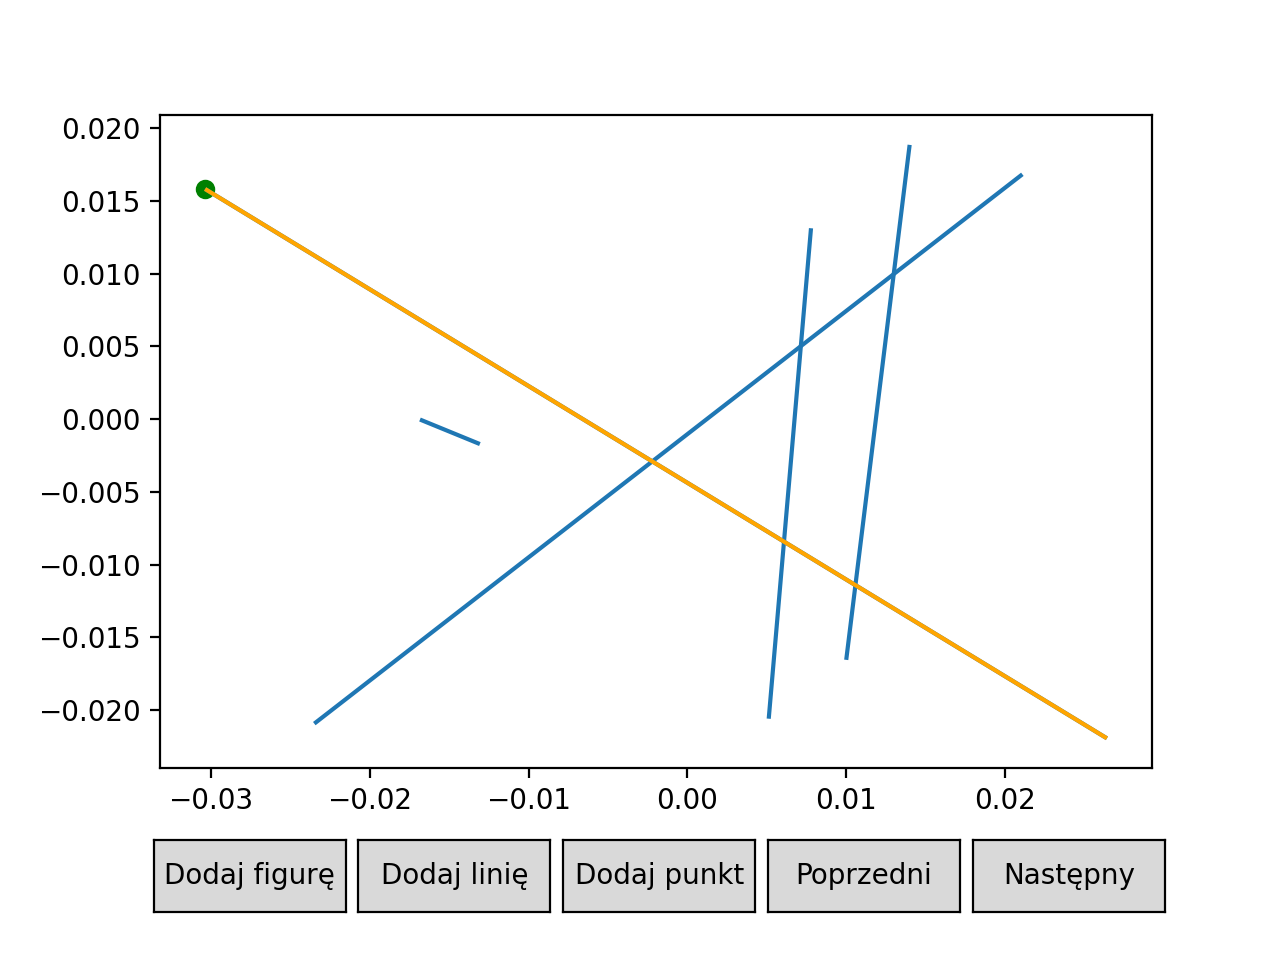

In [63]:
lines = plot.get_added_lines()[0].lines
points, scenes = sweep(lines)
print(len(points))
plot = Plot(scenes)
plot.draw()

## Generowane punkty

<IPython.core.display.Javascript object>


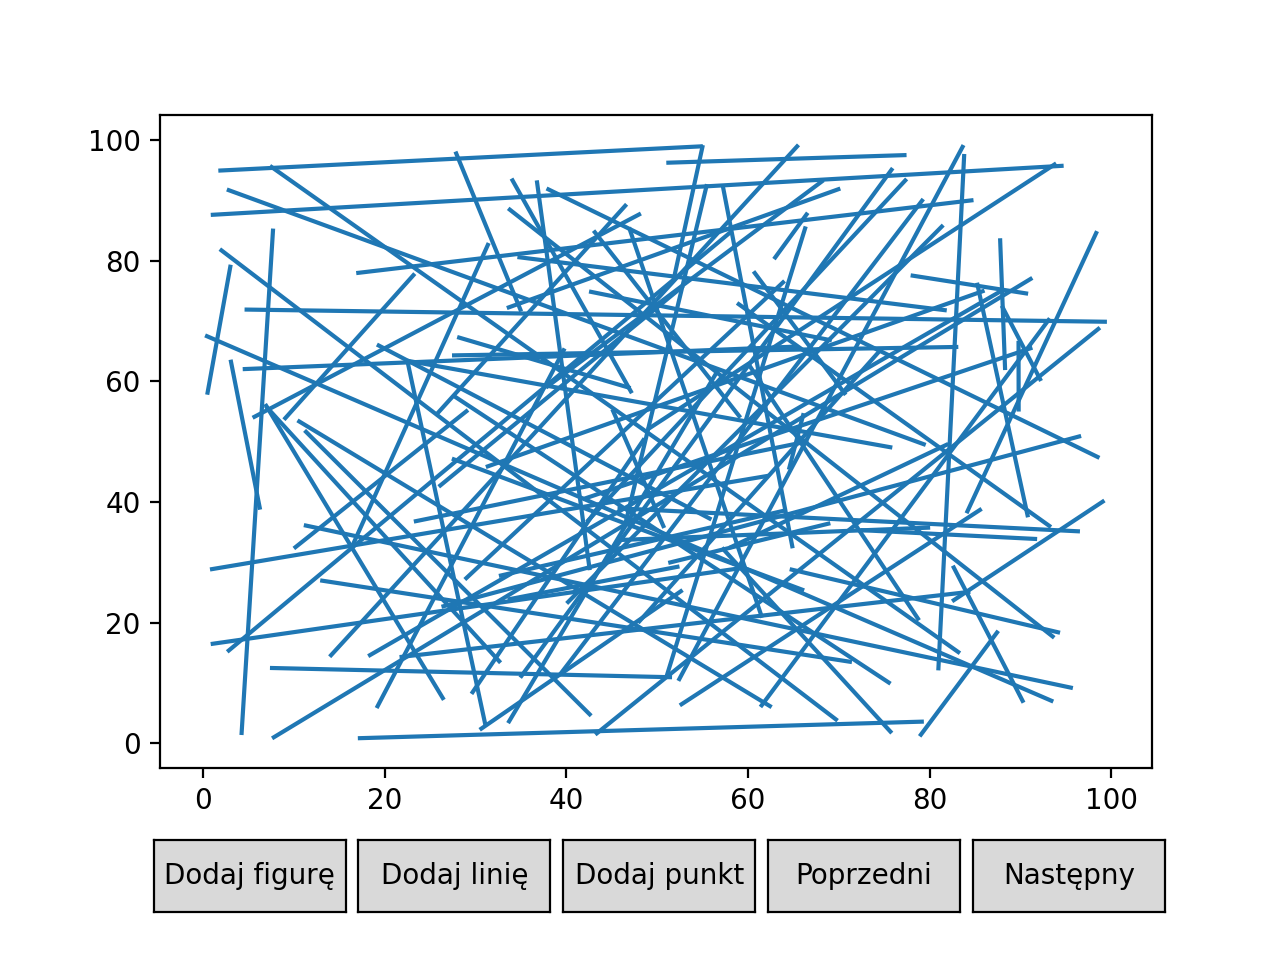

In [64]:
%matplotlib notebook
lines = generate_line(0, 100,100) 
q_scene = Scene([],lines = [LinesCollection(lines)])
plot=Plot(scenes = [q_scene])
plot.draw()

<IPython.core.display.Javascript object>


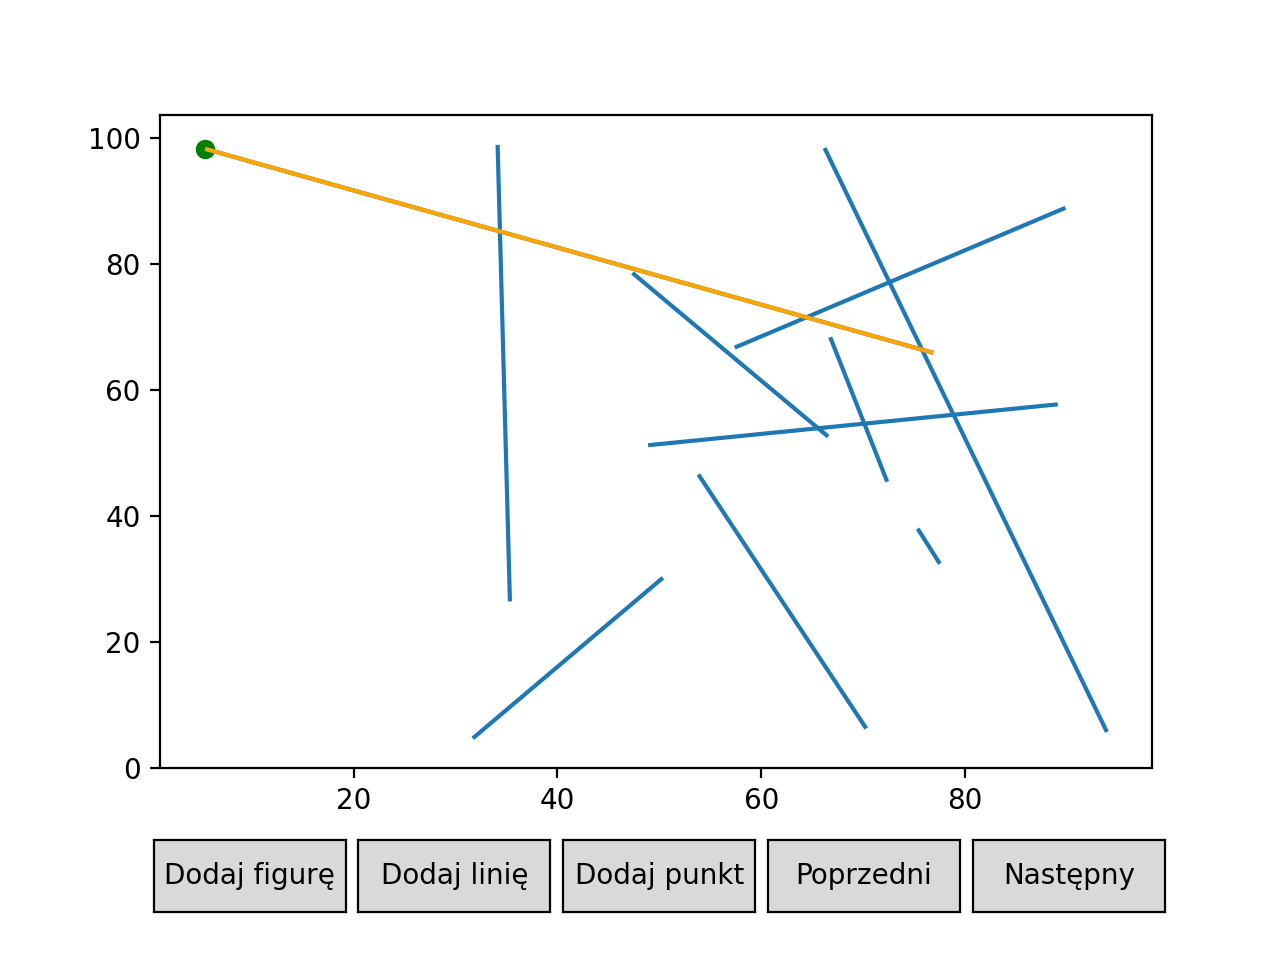

In [44]:
scenes = sweep(lines)[1]
plot = Plot(scenes)
plot.draw()